# Model Selection

## Importing Libraries

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# %load_ext nb_black

# Defaults
plt.rcParams["figure.figsize"] = (20.0, 10.0)
plt.rcParams.update({"font.size": 12, "figure.dpi": 120})
# pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")  # specify to ignore warning messages

## Data Handling

In [2]:
def preprocess(df):
    df = df.drop(["Lat", "Long"], axis=1)
    df = df.groupby(["Country/Region"], as_index=False).sum()
    df.loc[-1] = df.sum()
    df.loc[-1, "Country/Region"] = "Worldwide"
    countries = [
        "US",
        "Germany",
        "Spain",
        "United Kingdom",
        "France",
        "India",
        "Iran",
        "Italy",
        "Russia",
        "Turkey",
        #         "Worldwide",
    ]
    df = df.loc[df["Country/Region"].isin(countries)]
    df.reset_index(drop=True, inplace=True)
    df = df.set_index("Country/Region")
    df.columns = pd.to_datetime(df.columns)
    df = df.T
    return df

In [3]:
confirmed_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
)
confirmed_df = preprocess(confirmed_df)
deaths_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
)
deaths_df = preprocess(deaths_df)
recovered_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
)
recovered_df = preprocess(recovered_df)

In [4]:
active_df = pd.DataFrame(confirmed_df - deaths_df - recovered_df)
#active_df.plot(figsize=(15, 5))
#plt.show()

In [5]:
#confirmed_df.plot(figsize=(15, 5))
#plt.show()

In [6]:
#deaths_df.plot(figsize=(15, 5))
#plt.show()

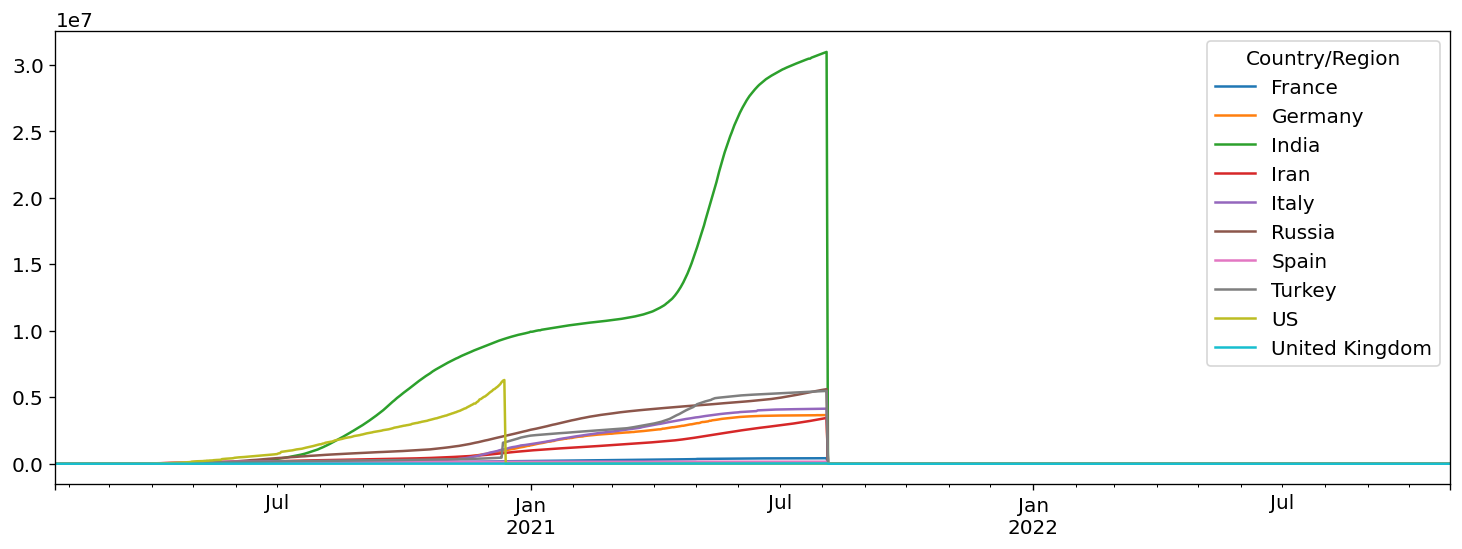

In [19]:
recovered_df.plot(figsize=(15, 5))
plt.show()

### Train test split

In [8]:
#active_train = active_df["2020-01-22":"2021-04-22"]
active_train = active_df["2020-02-04":"2020-05-20"]
active_test = active_df["2021-04-23":"2021-04-08"]
confirmed_train = confirmed_df["2020-01-22":"2021-04-22"]
confirmed_test = confirmed_df["2021-04-23":"2021-04-08"]

## Model Selection

### Determining order of differencing (d)

In [9]:
# Original Series
country = "India"
df = pd.DataFrame((active_train[country].to_numpy()), columns = {'cases'})

In [10]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.077511
p-value: 0.998766
Critical Values:
	1%: -3.496
	5%: -2.890
	10%: -2.582


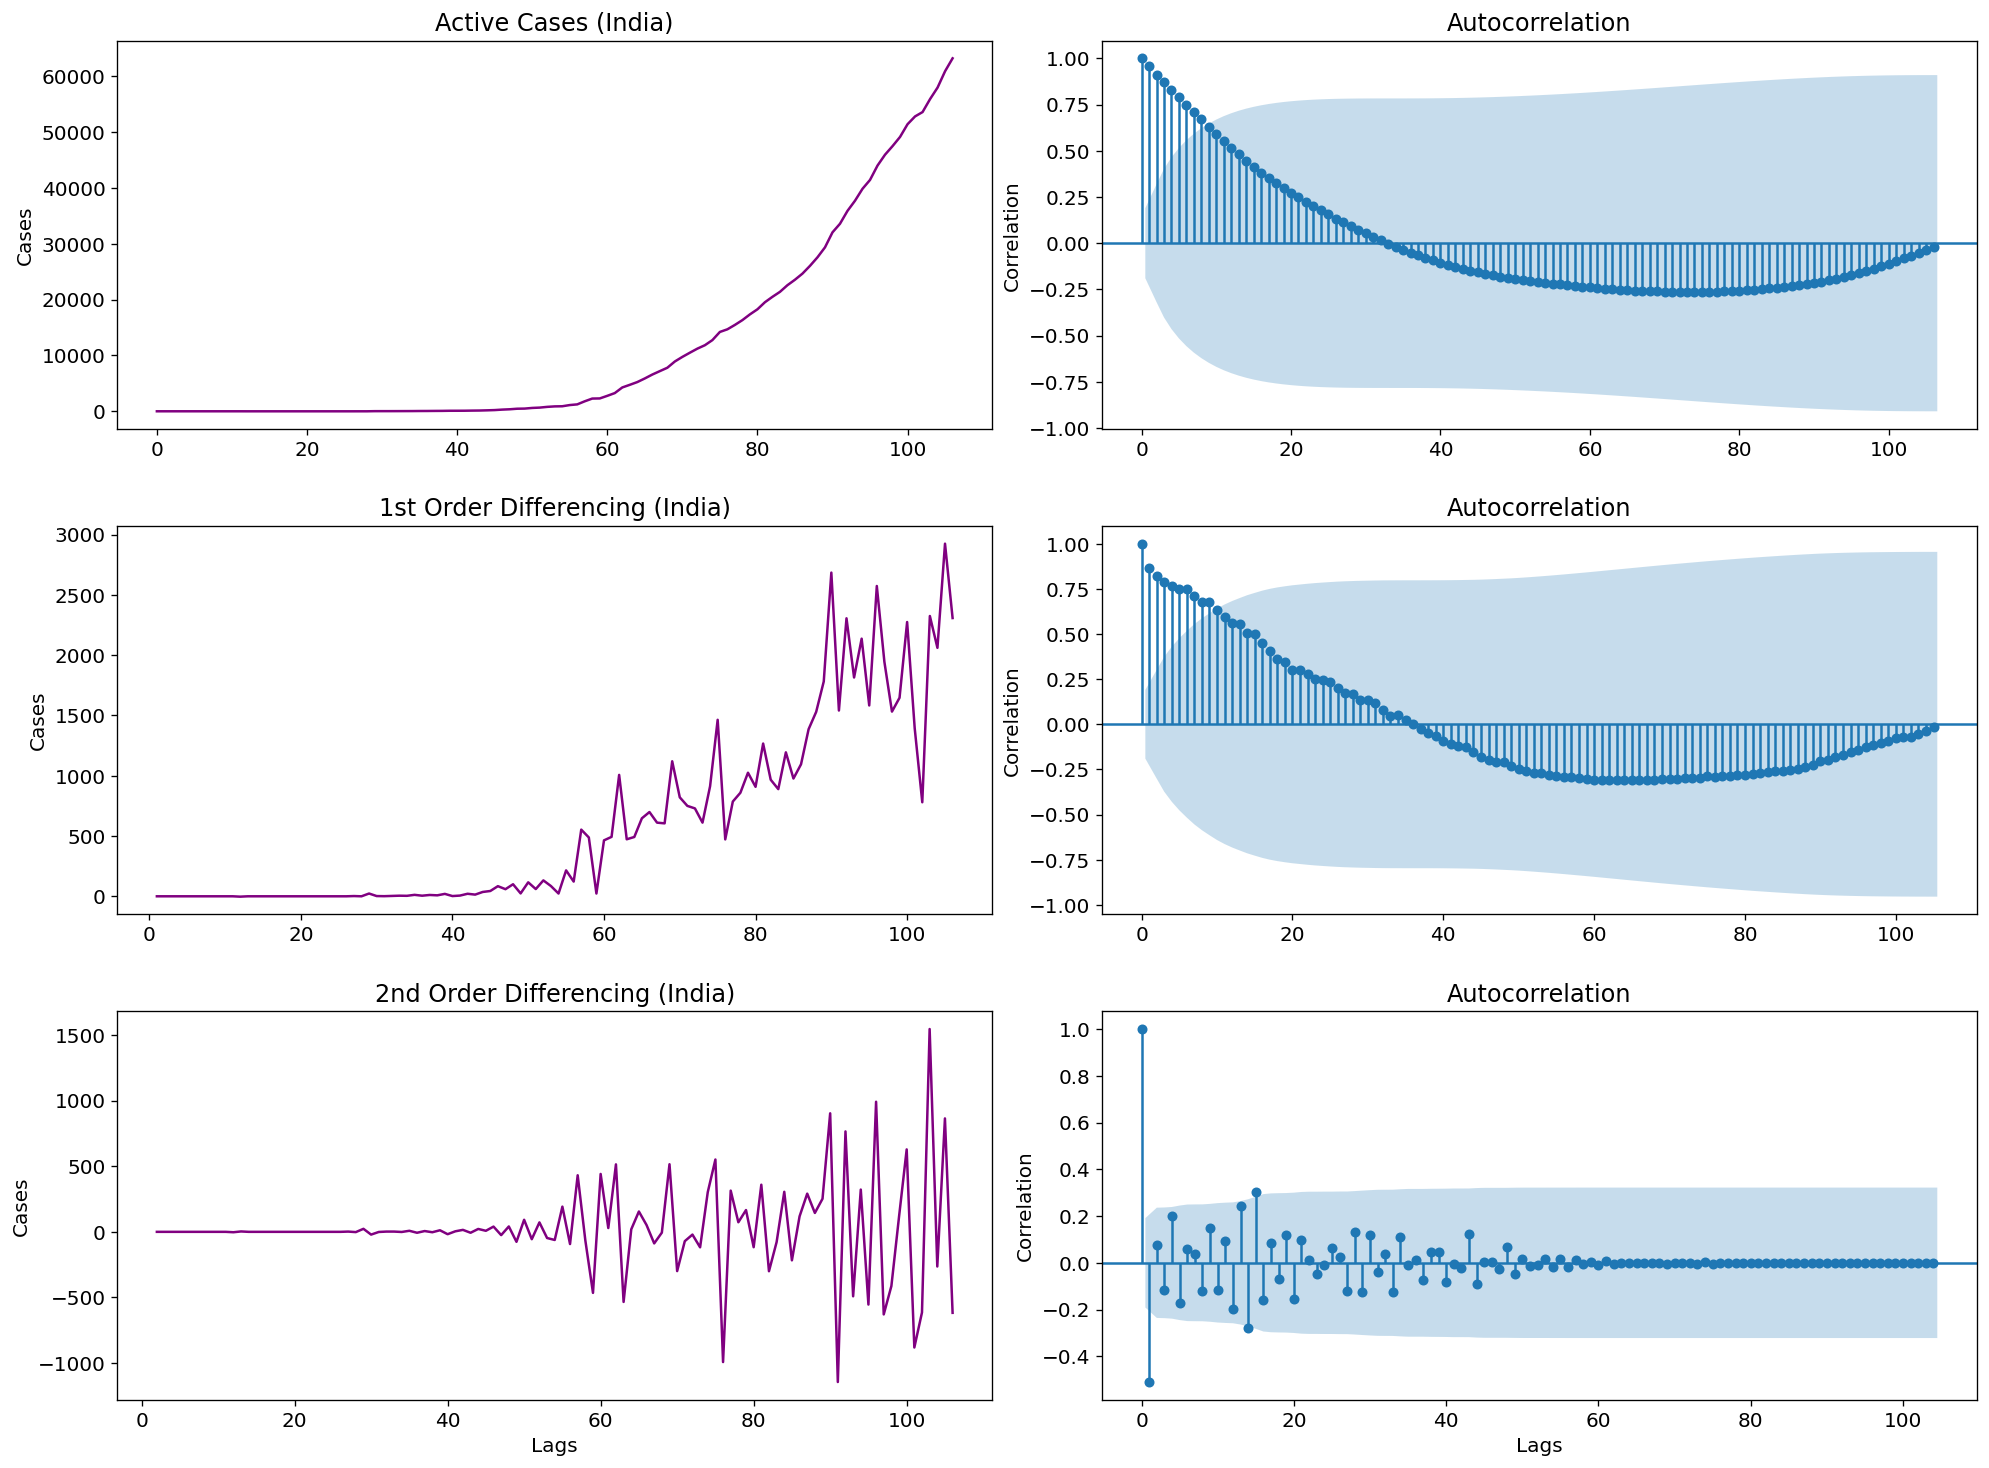

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(hspace=0.250, wspace=0.125)
axes[0, 0].plot(df, "purple")
axes[0, 0].set(title=f"Active Cases ({country})", ylabel="Cases")
plot_acf(df, ax=axes[0, 1], lags=df.shape[0] - 1)
axes[0, 1].set(ylabel="Correlation")

# 1st Differencing
axes[1, 0].plot(df.diff(), "purple")
axes[1, 0].set(title=f"1st Order Differencing ({country})", ylabel="Cases")
plot_acf(df.diff().dropna(), ax=axes[1, 1], lags=df.shape[0] - 2)
axes[1, 1].set(ylabel="Correlation")


# 2nd Differencing
axes[2, 0].plot(df.diff().diff(), "purple")
axes[2, 0].set(
    xlabel="Lags", ylabel="Cases", title=f"2nd Order Differencing ({country})"
)
axes[2, 1].set_xlabel("Lags")
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1], lags=df.shape[0] - 3)
axes[2, 1].set(ylabel="Correlation")

fig.savefig("Graphs/1.acf_plots.jpg")
plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the second differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.
$$d = 1 $$

### Determining order of Auto-Regression (p)

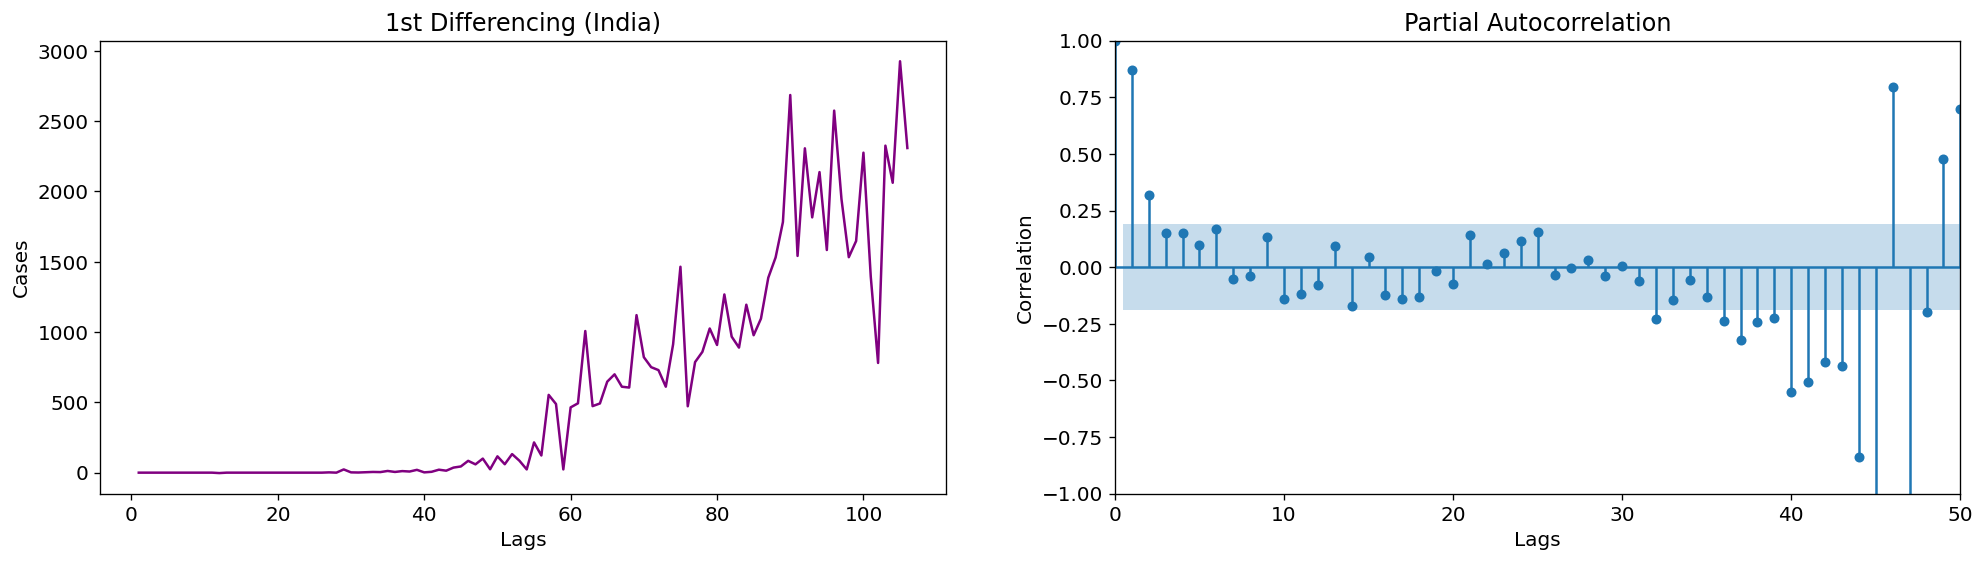

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(df.diff(), "purple")
ax1.set(title=f"1st Differencing ({country})", xlabel="Lags", ylabel="Cases")
plot_pacf(df.diff().dropna(), ax=ax2, lags=df.shape[0] / 2 - 1)
ax2.set(xlabel="Lags", ylabel="Correlation", ylim=(-1, 1), xlim=(0, 50))
fig.savefig("Graphs/2.pacf_plots.jpg")
plt.show()

It can observed that the PACF lag 1, 2 and 3 are quite significant since they are well above the significance limit, the blue region.
So we will use:
$$p \in \{1, 2, 3\}$$

### Determining order of Moving Average (q)

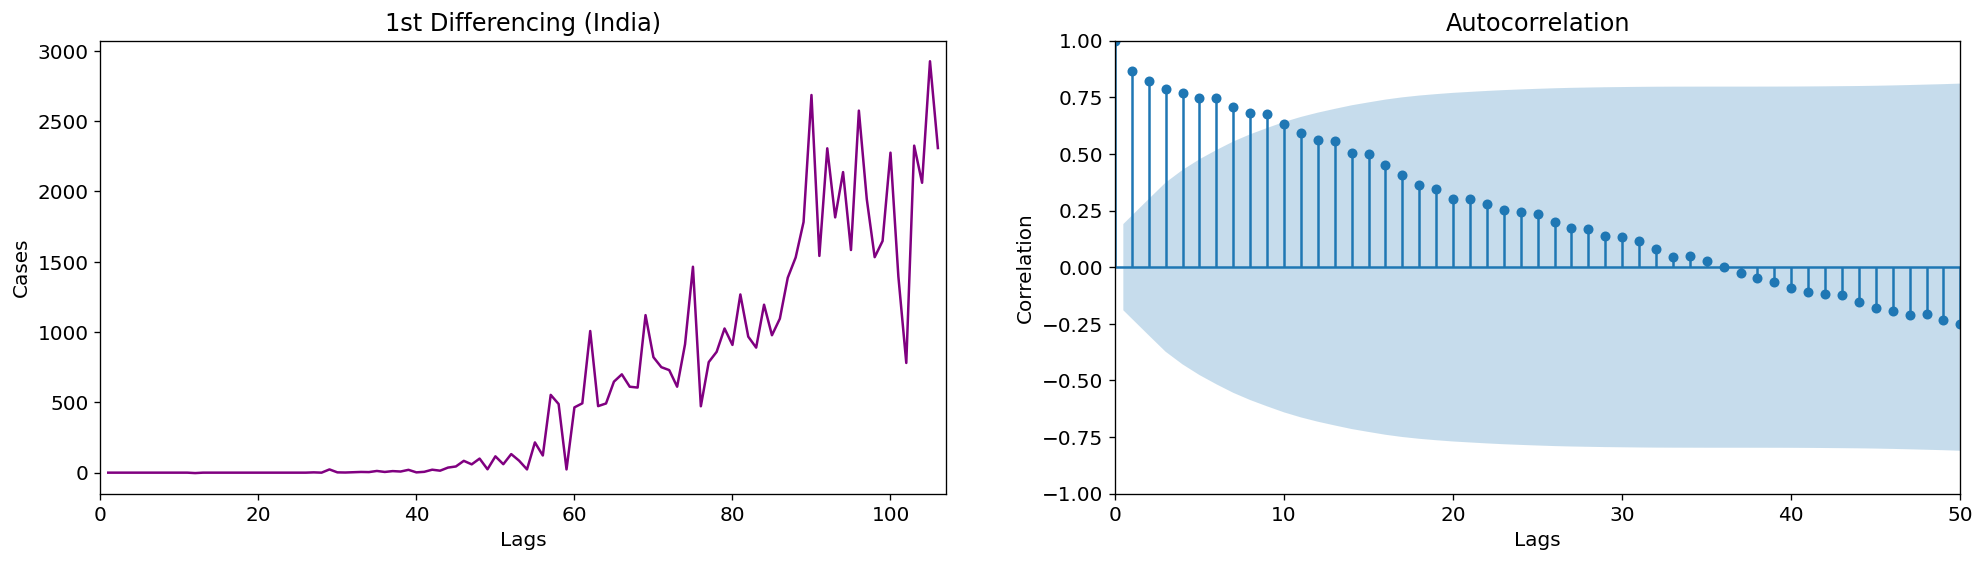

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(df.diff(), "purple")
axes[0].set(
    title=f"1st Differencing ({country})",
    xlabel="Lags",
    ylabel="Cases",
    xlim=(0, df.shape[0]),
)
plot_acf(df.diff().dropna(), ax=axes[1], lags=df.shape[0] - 2)
axes[1].set(ylim=(-1, 1), xlim=(0, 50), xlabel="Lags", ylabel="Correlation")

fig.savefig("Graphs/3.acf_plots.jpg")
plt.show()

We can see that upto `lags` = 9, the correlation is above the significance range and so we can conclude that: $$q \in [1, 9]$$

In [14]:
# Define the p, d, q parameters
p = range(1, 4)
d = 1
q = range(1, 10)

In [15]:
print(len(df))

107


In [16]:
RMSE = []
ARIMA_model = []

mod = sm.tsa.arima.ARIMA(df, order=(11, 1, 5), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(f"ARIMA - MSE:{results.mse}", end="\r")
RMSE.append(math.sqrt(results.mse))
# ARIMA_model.append(param)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  107
Model:                ARIMA(11, 1, 5)   Log Likelihood                -675.792
Date:                Thu, 01 Dec 2022   AIC                           1385.583
Time:                        10:48:20   BIC                           1428.999
Sample:                             0   HQIC                          1403.127
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8415      4.133     -0.204      0.839      -8.943       7.260
ar.L2         -0.4158      1.720     -0.242      0.809      -3.787       2.955
ar.L3          0.3192      1.249      0.256      0.7

In [20]:
RMSE

[278.7220785712021]

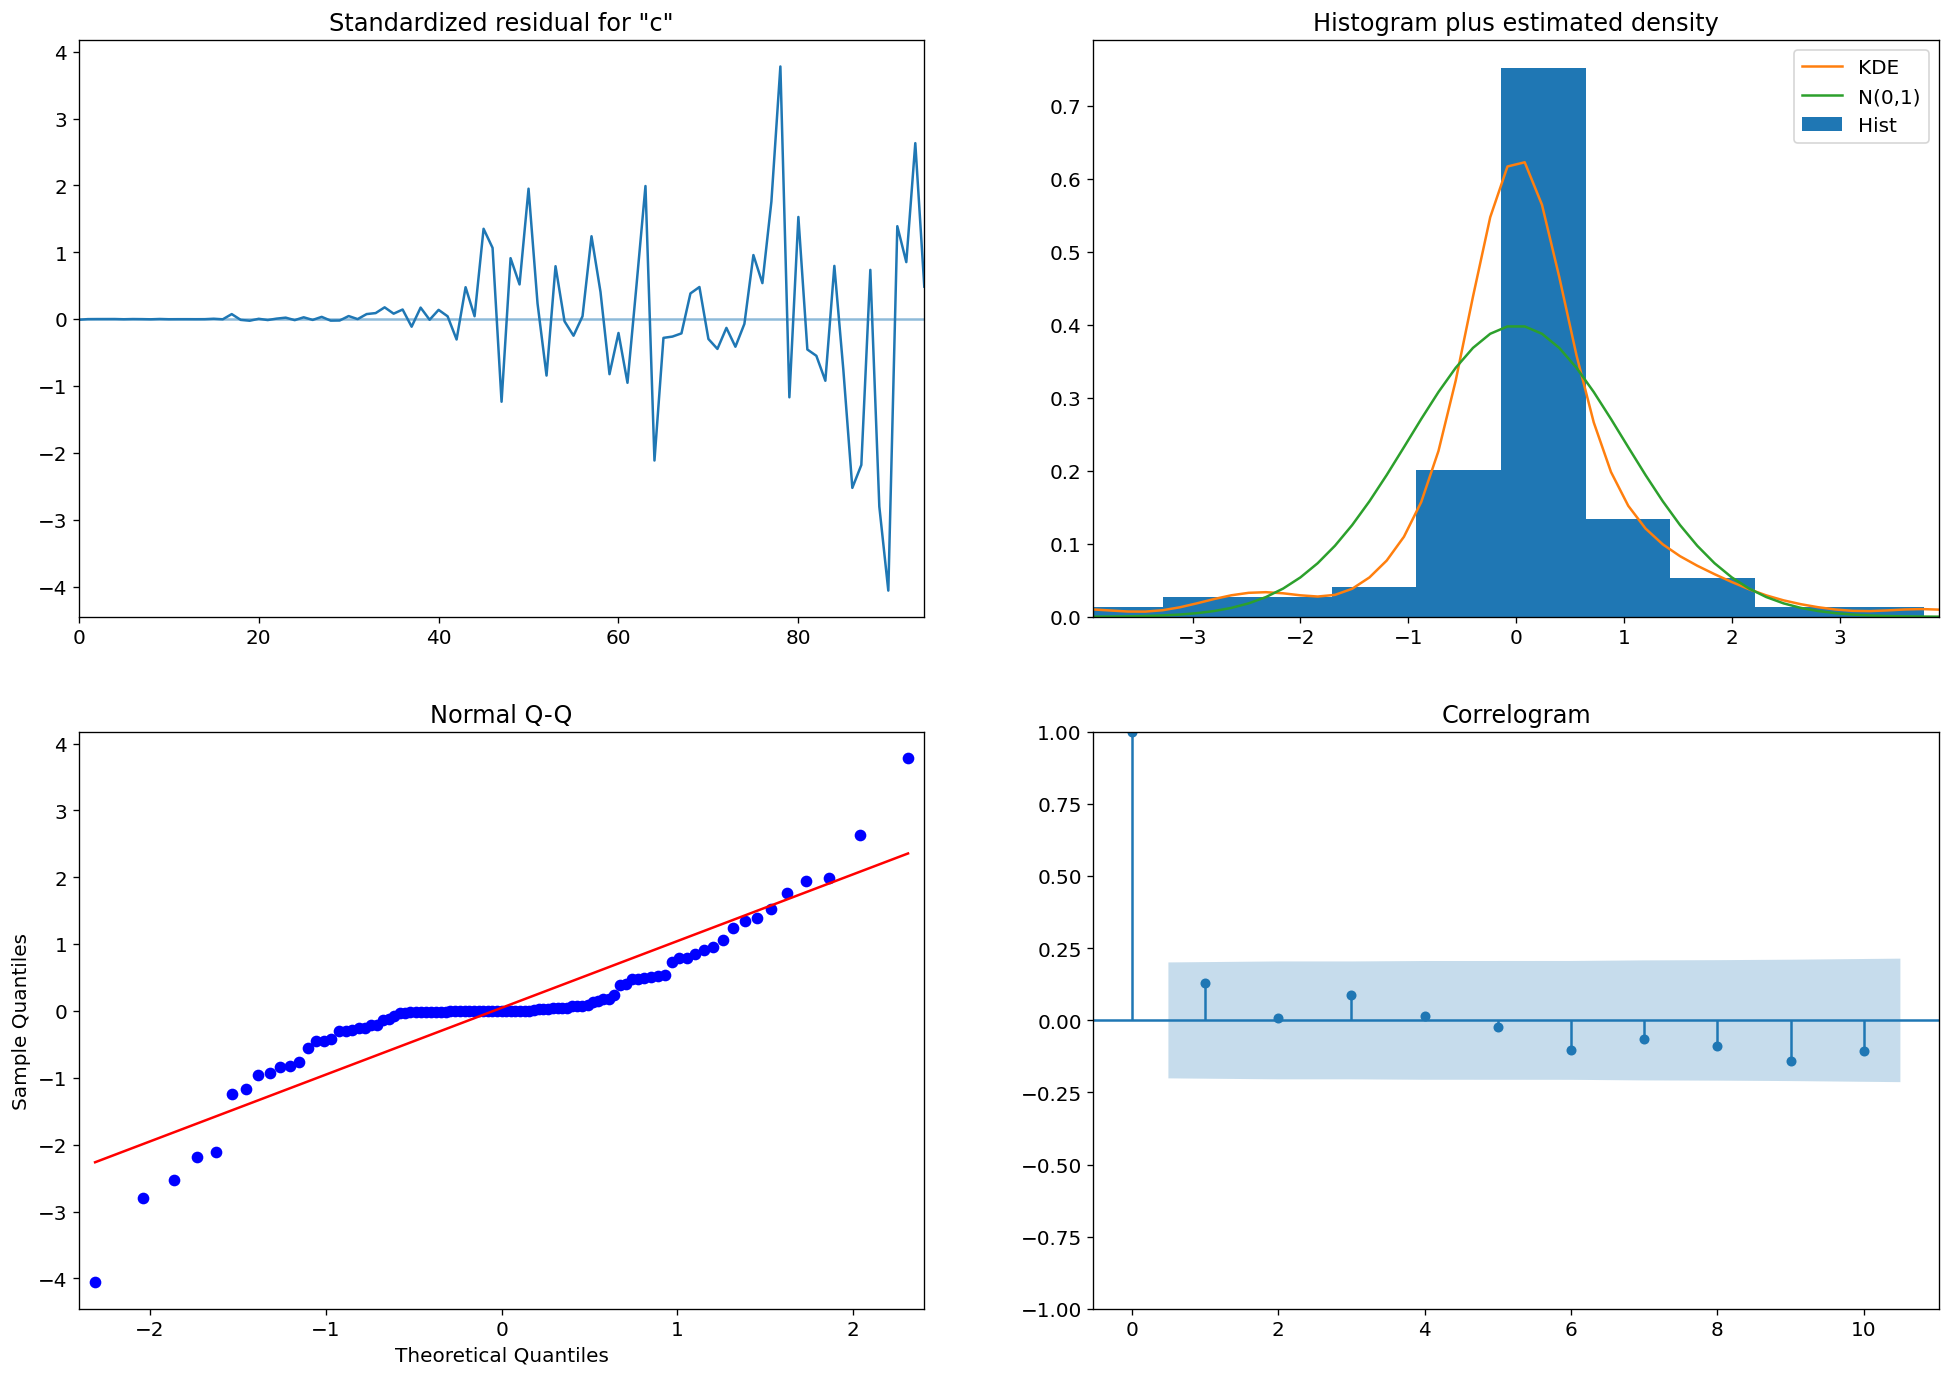

In [21]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [24]:
testdata = active_df["2020-01-22":"2021-04-22"]
testdf = pd.DataFrame((testdata['India'].to_numpy()), columns = {'cases'})

<AxesSubplot:>

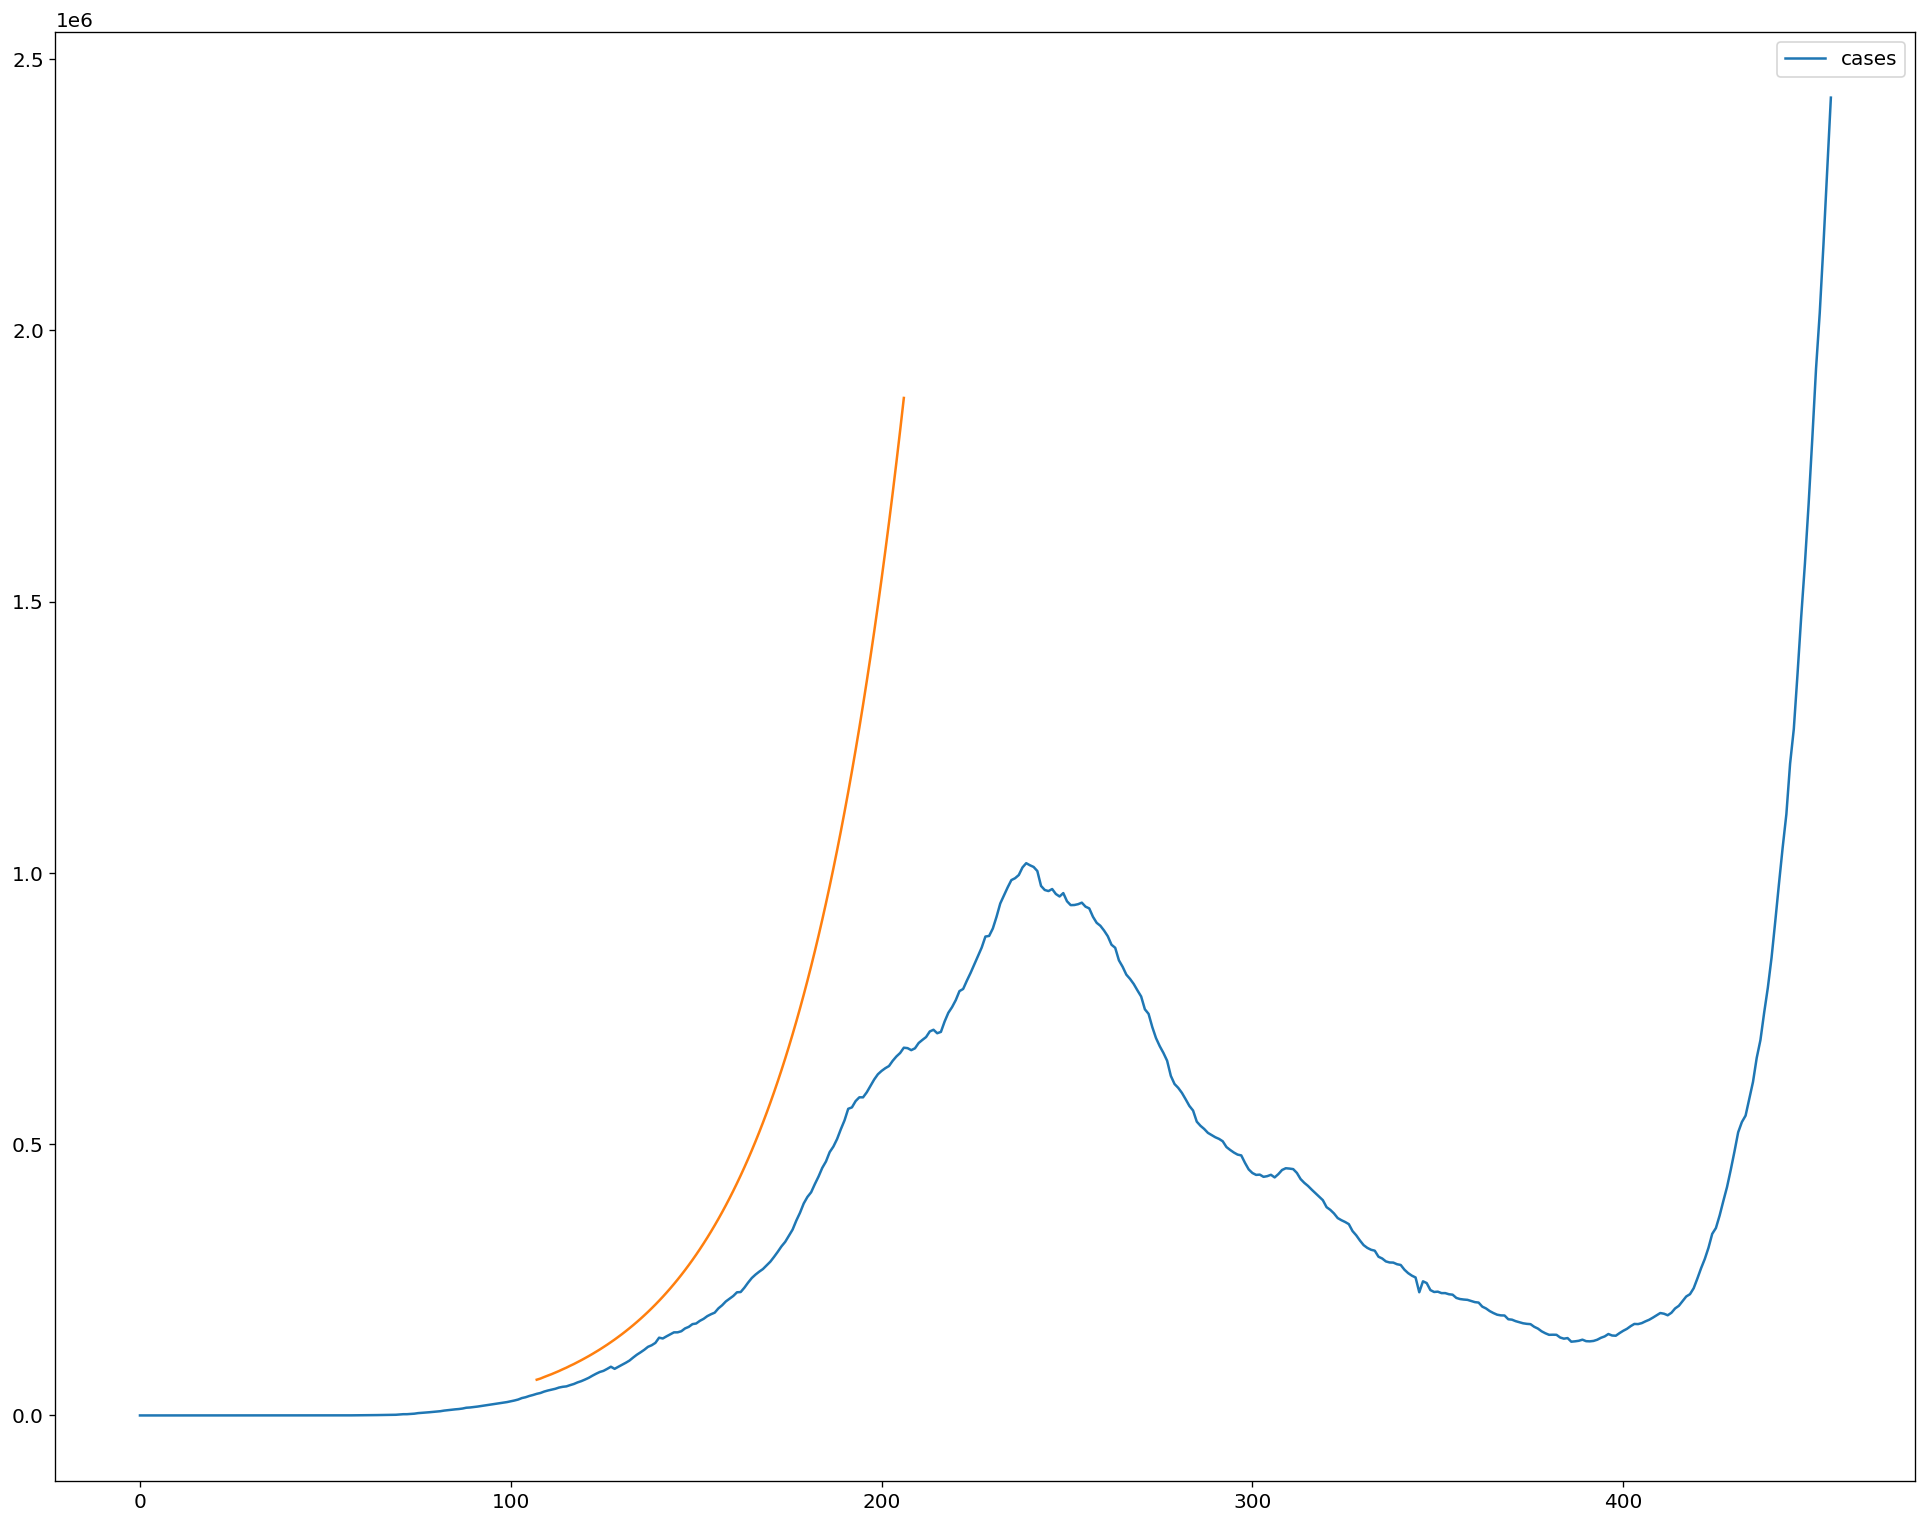

In [25]:
pred = results.get_forecast(100)
ax = testdf.plot(figsize=(20, 16))
pred.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')

In [18]:
print(
    f"The smallest MSE is {min(MSE)} for model ARIMA {ARIMA_model[MSE.index(min(MSE))][0]}x{ARIMA_model[MSE.index(min(MSE))][1]}"
)

NameError: name 'MSE' is not defined

In [ ]:
print(ARIMA_model)

In [ ]:
mod = sm.tsa.ARIMA(active_train['Worldwide'],
                                order=ARIMA_model[MSE.index(min(MSE))],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()